# Crypto prices 

This section we process the historical prices data and find dates where there are unusually high increase in prices, or decrease in prices

In [1]:
import os
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

In [2]:
directory = r"C:\Users\peace\Documents\GitHub\CryptocurrencyAnalysis\Data\Crypto_Data"
os.chdir(directory)
os.getcwd()

'C:\\Users\\peace\\Documents\\GitHub\\CryptocurrencyAnalysis\\Data\\Crypto_Data'

In [3]:
# Read on bitcoin data and provide the percentage change on a daily basis

bitcoin = pd.read_csv("BitcoinData.csv")
doge = pd.read_csv("DogecoinData.csv")

crypto = doge

crypto["Date"] = crypto.Date.astype("string")
crypto["Price"] = crypto.Price.astype("string")
crypto["Open"] = crypto.Open.astype("string")

crypto["Price"] = crypto["Price"].str.replace(",","")
crypto["Open"] = crypto["Open"].str.replace(",","")
crypto['Price'] =pd.to_numeric(crypto['Price'])
crypto['Open'] = pd.to_numeric(crypto['Open'])

crypto["Change"] = round((crypto["Price"]-crypto["Open"])/crypto["Open"] * 100,3)

# Remove the timing from Date column as it provides no useful information
# get same format as compound score file
crypto["Date"] = crypto["Date"].apply(lambda x: pd.to_datetime(x))

#change bitcoin column name to be same as the compound score files
crypto.rename(columns={'Date': 'Datetime'}, inplace= True)

crypto["Datetime"] = crypto.Datetime.astype("string")
crypto

,Datetime,Price,Open,High,Low,Vol.,Change %,Change
0,2022-04-28,0.138149,0.139976,0.143221,0.135475,2.24B,-1.30%,-1.305
1,2022-04-27,0.139966,0.137684,0.145590,0.135230,3.41B,1.66%,1.657
2,2022-04-26,0.137684,0.157851,0.166093,0.136269,9.46B,-12.77%,-12.776
3,2022-04-25,0.157843,0.131732,0.169885,0.122725,10.48B,19.81%,19.821
4,2022-04-24,0.131746,0.133811,0.134709,0.131198,749.44M,-1.53%,-1.543
...,...,...,...,...,...,...,...,...
1574,2018-01-05,0.012550,0.009613,0.013950,0.009434,672.26M,30.55%,30.552
1575,2018-01-04,0.009613,0.009205,0.010300,0.008559,634.48M,4.43%,4.432
1576,2018-01-03,0.009205,0.009000,0.009345,0.008340,724.34M,2.28%,2.278
1577,2018-01-02,0.009000,0.008678,0.009878,0.008316,721.15M,3.71%,3.711


We remove the timing from Date column as it provides no useful information

### Now we define the standard for identifying unusual days

By central limit theorem, assume price change is normally distributed. @ 99.38% level of confidence (plus minus 2.5 SD)
we consider anything outside of this upper and lower limits @ 99.38% level of confidence unusual.


In [4]:
sd = 2.5

mean_change = crypto.describe()["Change"]['mean']
sd_change = crypto.describe()["Change"]['std']

tolerance_upper = mean_change + sd*sd_change
tolerance_lower = mean_change - sd*sd_change
print("We define days with usual price movements as {}% increase and {}% decrease".format(round(tolerance_upper,3),round(tolerance_lower,3)))

We define days with usual price movements as 32.046% increase and -31.019% decrease


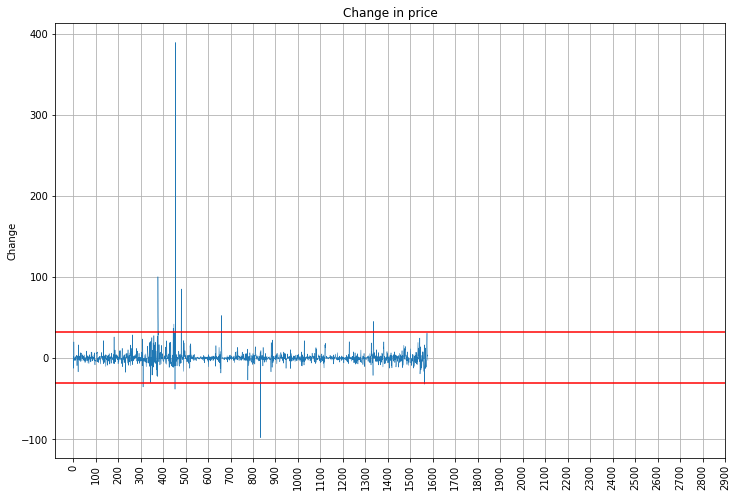

In [5]:
fig, ax1 = plt.subplots(figsize=(12,8))
graph = sns.lineplot(data = crypto, x=crypto.index, y='Change',markers = True,linewidth = 0.5)
ax1.set(title='Change in price')
plt.xticks(np.arange(0,3000,100),rotation = 90)
graph.axhline(tolerance_upper, color = "red")
graph.axhline(tolerance_lower, color = "red")
plt.grid()
plt.show()

In [6]:
unusual_dates_high = {}
unusual_dates_low = {}

for i in crypto["Change"]:
    if i>0 and i>tolerance_upper:
        unusual_dates_high[crypto["Datetime"][crypto.Change == i ].values[0]] = i
    elif i<0 and i<tolerance_lower:
        unusual_dates_low[crypto["Datetime"][crypto.Change == i ].values[0]] = i

print("Dates that have high price increase")
print(unusual_dates_high)
print("\n")
print("Dates that have large drop in price")
print(unusual_dates_low)

Dates that have high price increase
{'2021-04-16': 100.162, '2021-04-15': 50.719, '2021-04-13': 32.604, '2021-02-07': 36.521, '2021-02-04': 41.789, '2021-01-28': 389.076, '2021-01-02': 85.089, '2020-07-08': 52.419, '2018-09-01': 33.9, '2018-08-31': 45.14}


Dates that have large drop in price
{'2021-06-21': -35.743, '2021-01-30': -38.514, '2020-01-16': -98.433, '2018-01-16': -32.337}


# Sentiment Analysis of Tweets from Influencers

This section we extract tweets and process them

## Scrap Tweets from all excel file in a folder

1) Change your directory to the folder with all the excel files

2) Tweet columns scrapped are
    
    -Datetime
    
    -Tweet ID
    
    -Text
    
    -Username

In [9]:
# assign directory
directory = r"C:\Users\peace\Documents\GitHub\CryptocurrencyAnalysis\Data\Twitter_Data\Influencers' Tweets"
os.chdir(directory)

df_consolidated = pd.DataFrame()

# iterate over files in that directory
for filename in os.listdir(r"C:\Users\peace\Documents\GitHub\CryptocurrencyAnalysis\Data\Twitter_Data\Influencers' Tweets"):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        df = pd.read_csv(filename)
        df_consolidated = pd.concat([df_consolidated, df],ignore_index = True)
        
df_consolidated

,Unnamed: 0,Datetime,Tweet Id,Text,Username
0,0,2019-01-30 23:48:18+00:00,1090758635024728069,"Jury awards Rand Paul more than $580,000 in da...",business
1,1,2019-01-30 23:37:40+00:00,1090755959029403648,Facebook investors shouldn't get lulled into a...,business
2,2,2019-01-30 23:29:19+00:00,1090753856148070401,"As Tesla bond comes due, a Chinese challenger ...",business
3,3,2019-01-30 23:23:29+00:00,1090752391304134656,Should New York City ride-share drivers get a ...,business
4,4,2019-01-30 23:20:22+00:00,1090751604972769280,"More than 1,000 confidential files somehow fou...",business
...,...,...,...,...,...
369527,311,2022-05-01 09:01:09+00:00,1520689773005877248,"@MacaesBruno Sure but as Poland shows, indepen...",VitalikButerin
369528,312,2022-05-01 08:04:08+00:00,1520675422005960704,@MacaesBruno Can you elaborate? I'm seeing lot...,VitalikButerin
369529,313,2022-05-01 04:32:24+00:00,1520622139069452289,@zengjiajun_eth The only solution is to unders...,VitalikButerin
369530,314,2022-05-01 04:31:06+00:00,1520621813209784321,@zengjiajun_eth Don't think optimizing the con...,VitalikButerin


Change datetime column to string type so we can clean it

In [10]:
df_consolidated["Datetime"]=df_consolidated["Datetime"].astype("string")
df_consolidated["Datetime"] = df_consolidated["Datetime"].str[:10]
df_consolidated["Datetime"]=df_consolidated["Datetime"].astype("string")
df_consolidated["Datetime"]

0         2019-01-30
1         2019-01-30
2         2019-01-30
3         2019-01-30
4         2019-01-30
             ...    
369527    2022-05-01
369528    2022-05-01
369529    2022-05-01
369530    2022-05-01
369531    2022-05-01
Name: Datetime, Length: 369532, dtype: string

### this section we explore whether prices with high increase, have positive sentiments

In [11]:
print("Dates that have high price increase")
print(unusual_dates_high)

Dates that have high price increase
{'2021-04-16': 100.162, '2021-04-15': 50.719, '2021-04-13': 32.604, '2021-02-07': 36.521, '2021-02-04': 41.789, '2021-01-28': 389.076, '2021-01-02': 85.089, '2020-07-08': 52.419, '2018-09-01': 33.9, '2018-08-31': 45.14}


In [12]:
res = []
for i in unusual_dates_high.keys():
    res.extend(df_consolidated.index[df_consolidated["Datetime"] == i].tolist())

df_high = df_consolidated.loc[res]


## Tweets pre-processing

We remove all @ and hyperlinks using regex, but keep hashtags as they can provide insights

In [13]:
df_high

,Unnamed: 0,Datetime,Tweet Id,Text,Username
232451,27243,2021-04-16,1383208101088739330,The FBI says that last year it questioned the ...,business
232452,27244,2021-04-16,1383208101084590081,Raul Castro makes it official that he plans to...,business
232453,27245,2021-04-16,1383207864995618816,Elon Musk’s SpaceX was too cheap to make a Tex...,business
232454,27246,2021-04-16,1383201058789466113,Argentine soccer legend Carlos Tevez has filed...,business
232455,27247,2021-04-16,1383200052068417539,Biden calls a recent spate of mass shootings i...,business
...,...,...,...,...,...
366890,3206,2020-07-08,1280923713563754499,@danfinlay @jinglanW Against restricting Chine...,VitalikButerin
366891,3207,2020-07-08,1280922321369341953,"@jinglanW In somewhat related news, in additio...",VitalikButerin
366892,3208,2020-07-08,1280842689219645440,@APompliano Bipolar?\n\nLooks like EU technoph...,VitalikButerin
366893,3209,2020-07-08,1280674118136889345,@RealNavitro @rahulsood @MichelleRempel Yeah t...,VitalikButerin


In [14]:
all_tweets = []

#remove multiple \n in tweets, and lowercase all characters
for tweets in df_high["Text"]:
    res = tweets.replace("\n"," ")+"\n"
    all_tweets.append(res.strip("\n").lower())

#remove all @ and hyperlinks
for i in range(len(all_tweets)):
    all_tweets[i] = re.sub(r"@\w+","",all_tweets[i])
    all_tweets[i] = re.sub(r"\bhttps://.+\b","",all_tweets[i])

all_tweets

['the fbi says that last year it questioned the man who fatally shot 8 people thursday at a fedex plant in indianapolis (via ap) ',
 "raul castro makes it official that he plans to step down as cuba's communist party head, ending his family’s six-decade grip of the island ",
 'elon musk’s spacex was too cheap to make a texas roadway safe, leading to a traffic accident that killed a local man, the victim’s attorney claims in a lawsuit ',
 'argentine soccer legend carlos tevez has filed a court injunction to avoid paying a new wealth tax ',
 'biden calls a recent spate of mass shootings in the u.s. a “national embarrassment” and challenges the senate to take up a gun-control bill passed by the house ',
 "the head of new york's dalton school is leaving after a tumultuous year ",
 'the u.s. said china continues to focus its policies on exports, and called on its biggest economic rival to implement forceful measures to boost domestic demand ',
 'here’s the latest on the coronavirus pandemic

Next we filter all tweets using keywords in the filter_crypto list, we are only interested to see tweets related to cryptocurrencies and its related subjects

In [15]:
filter_crypto = ["eth","bitcoin","coindesk"," ethereum","crypto","cryptography","cryptocurrency","nfts","nft's","coin","doge","dogecoin","stablecoin","fiat","token","mine","mining","miners","altcoin","blockchain","hodl","wallet","wallets"]
crypto_tweets = []
# as long as one of the filter words are in the tweets, we capture them
for tweets in all_tweets:
    for i in filter_crypto:
        if i in tweets:
            crypto_tweets.append(tweets)
            break
            
print("From {} number of tweets, this influencer has tweeted {} related to crypto".format(len(all_tweets),len(crypto_tweets)))

From 2641 number of tweets, this influencer has tweeted 154 related to crypto


In [16]:
crypto_tweets

["what's the investment outlook for assets such as coinbase and jpmorgan that were in the news this week? ",
 'the quality of your coffee may soon be determined by a robot ',
 'u.s. publicly-listed companies more than quadrupled the appointment of latino executives to their boards in the first quarter, a small step toward addressing ethnic and racial inequality across the top corporate ranks ',
 "facebook's content oversight board has extended the timeline for its decision on whether trump's ban from the network should stay in place ",
 'dogecoin, boosted by the likes of elon musk and mark cuban, rallied roughly 180% friday reaching a market value of more than $48 billion ',
 'covid-19 inflicted deep wounds on cultural institutions that depend on live audiences. but the pandemic also offered them a chance to rethink their strategies, 92nd street y ceo seth pinsky says  ',
 "the biden administration is considering taking aim at methane before next week's climate summit ",
 'yale economi

Next, we tokenize the processed tweets, to conduct our sentiment analysis. 

In [17]:
def is_valid_token(token):
    # keep hashtag, but not user mentions, i've retained the code for keeping user mentions
    # if ((token.startswith('#') or token.startswith('@')) and len(token) > 2):
    if (token.startswith('#') and len(token) > 2):
        return True
    # if a token contains at least two consective English letters, we assume it's a word
    if re.match(r'.*[a-z]{2,}.*', token):
        return True
    return False

tt = TweetTokenizer()
crypto_tokens = [tt.tokenize(doc) for doc in crypto_tweets]
crypto_tokens = [[token for token in doc if is_valid_token(token)] for doc in crypto_tokens]
crypto_tokens

[["what's",
  'the',
  'investment',
  'outlook',
  'for',
  'assets',
  'such',
  'as',
  'coinbase',
  'and',
  'jpmorgan',
  'that',
  'were',
  'in',
  'the',
  'news',
  'this',
  'week'],
 ['the',
  'quality',
  'of',
  'your',
  'coffee',
  'may',
  'soon',
  'be',
  'determined',
  'by',
  'robot'],
 ['publicly-listed',
  'companies',
  'more',
  'than',
  'quadrupled',
  'the',
  'appointment',
  'of',
  'latino',
  'executives',
  'to',
  'their',
  'boards',
  'in',
  'the',
  'first',
  'quarter',
  'small',
  'step',
  'toward',
  'addressing',
  'ethnic',
  'and',
  'racial',
  'inequality',
  'across',
  'the',
  'top',
  'corporate',
  'ranks'],
 ["facebook's",
  'content',
  'oversight',
  'board',
  'has',
  'extended',
  'the',
  'timeline',
  'for',
  'its',
  'decision',
  'on',
  'whether',
  "trump's",
  'ban',
  'from',
  'the',
  'network',
  'should',
  'stay',
  'in',
  'place'],
 ['dogecoin',
  'boosted',
  'by',
  'the',
  'likes',
  'of',
  'elon',
  'musk

In [18]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# remove stop words
stop_set = set(stopwords.words('english'))
crypto_tokens = [[token for token in doc if token not in stop_set] for doc in crypto_tokens]

# # stemming
# stemmer = PorterStemmer()
# # only perform stemming on tokens not starting with # or @
# crypto_tokens = [[token if token.startswith('#') or token.startswith('@') else stemmer.stem(token) for token in doc] for doc in crypto_tokens]

# remove documents with fewer than three words
crypto_tokens = [doc for doc in crypto_tokens if len(doc) >= 3]

In [19]:
crypto_tokens

[["what's",
  'investment',
  'outlook',
  'assets',
  'coinbase',
  'jpmorgan',
  'news',
  'week'],
 ['quality', 'coffee', 'may', 'soon', 'determined', 'robot'],
 ['publicly-listed',
  'companies',
  'quadrupled',
  'appointment',
  'latino',
  'executives',
  'boards',
  'first',
  'quarter',
  'small',
  'step',
  'toward',
  'addressing',
  'ethnic',
  'racial',
  'inequality',
  'across',
  'top',
  'corporate',
  'ranks'],
 ["facebook's",
  'content',
  'oversight',
  'board',
  'extended',
  'timeline',
  'decision',
  'whether',
  "trump's",
  'ban',
  'network',
  'stay',
  'place'],
 ['dogecoin',
  'boosted',
  'likes',
  'elon',
  'musk',
  'mark',
  'cuban',
  'rallied',
  'roughly',
  'friday',
  'reaching',
  'market',
  'value',
  'billion'],
 ['covid',
  'inflicted',
  'deep',
  'wounds',
  'cultural',
  'institutions',
  'depend',
  'live',
  'audiences',
  'pandemic',
  'also',
  'offered',
  'chance',
  'rethink',
  'strategies',
  '92nd',
  'street',
  'ceo',
  'se

In [20]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def print_sentiment(model, doc):
    '''
    model: a sentiment model
    doc: a string representing a document
    '''
    print("Crypto Tweets Sentiments from this Influencer")
    ps = model.polarity_scores(doc)
    print('-' * 20)
    print('Positive:', '%.1f%%' % (ps['pos'] * 100))
    print('Negative:', '%.1f%%' % (ps['neg'] * 100))
    print('Neutral:', '%.1f%%' % (ps['neu'] * 100))
    print('Compound score (-1 to 1):', ps['compound'])
    print('-' * 20 + '\n')

# loading a pre-trained polarity model
model = SentimentIntensityAnalyzer()

Here we explore the overall sentiments of the tweets from this influencer during periods of high increase of prices in bitcoin

In [21]:
total_sentiments = ""

for i in crypto_tokens:
    total_sentiments = total_sentiments + " ".join(i) + " "
    
print_sentiment(model, total_sentiments)

Crypto Tweets Sentiments from this Influencer
--------------------
Positive: 11.5%
Negative: 12.3%
Neutral: 76.2%
Compound score (-1 to 1): -0.9768
--------------------



Here we explore the sentiments of the individual tweets from this influencer

In [22]:
for i in range(len(crypto_tokens)):
    print("Tweet: {}".format(crypto_tweets[i]))
    print("\n")
    print_sentiment(model," ".join(crypto_tokens[i]))
    

Tweet: what's the investment outlook for assets such as coinbase and jpmorgan that were in the news this week? 


Crypto Tweets Sentiments from this Influencer
--------------------
Positive: 19.5%
Negative: 0.0%
Neutral: 80.5%
Compound score (-1 to 1): 0.1779
--------------------

Tweet: the quality of your coffee may soon be determined by a robot 


Crypto Tweets Sentiments from this Influencer
--------------------
Positive: 32.4%
Negative: 0.0%
Neutral: 67.6%
Compound score (-1 to 1): 0.34
--------------------

Tweet: u.s. publicly-listed companies more than quadrupled the appointment of latino executives to their boards in the first quarter, a small step toward addressing ethnic and racial inequality across the top corporate ranks 


Crypto Tweets Sentiments from this Influencer
--------------------
Positive: 8.7%
Negative: 0.0%
Neutral: 91.3%
Compound score (-1 to 1): 0.2023
--------------------

Tweet: facebook's content oversight board has extended the timeline for its decision o

## This section, we explore the sentiments of tweets during days of large decrease in prices

In [23]:
res = []
for i in unusual_dates_low.keys():
    res.extend(df_consolidated.index[df_consolidated["Datetime"] == i].tolist())

df_low = df_consolidated.loc[res]

all_tweets = []

#remove multiple \n in tweets, and lowercase all characters
for tweets in df_low["Text"]:
    res = tweets.replace("\n"," ")+"\n"
    all_tweets.append(res.strip("\n").lower())

#remove all @ and hyperlinks
for i in range(len(all_tweets)):
    all_tweets[i] = re.sub(r"@\w+","",all_tweets[i])
    all_tweets[i] = re.sub(r"\bhttps://.+\b","",all_tweets[i])
    
filter_crypto = ["eth","bitcoin","coindesk"," ethereum","crypto","cryptocurrency","nfts","nft's","coin","doge","dogecoin","stablecoin","fiat","token","mine","mining","miners","altcoin","blockchain","hodl","wallet","wallets"]
crypto_tweets = []
# as long as one of the filter words are in the tweets, we capture them
for tweets in all_tweets:
    for i in filter_crypto:
        if i in tweets:
            crypto_tweets.append(tweets)
            break
            
tt = TweetTokenizer()
crypto_tokens = [tt.tokenize(doc) for doc in crypto_tweets]
crypto_tokens = [[token for token in doc if is_valid_token(token)] for doc in crypto_tokens]
crypto_tokens

# remove stop words
stop_set = set(stopwords.words('english'))
crypto_tokens = [[token for token in doc if token not in stop_set] for doc in crypto_tokens]

# remove documents with fewer than three words
crypto_tokens = [doc for doc in crypto_tokens if len(doc) >= 3]

total_sentiments = ""

for i in crypto_tokens:
    total_sentiments = total_sentiments + " ".join(i) + " "
    
print_sentiment(model, total_sentiments)



Crypto Tweets Sentiments from this Influencer
--------------------
Positive: 10.2%
Negative: 12.0%
Neutral: 77.9%
Compound score (-1 to 1): -0.9349
--------------------



In [24]:
for i in range(len(crypto_tokens)):
    print("Tweet: {}".format(crypto_tweets[i]))
    print("\n")
    print_sentiment(model," ".join(crypto_tokens[i]))
    

Tweet: microstrategy said it purchased an additional 13,005 bitcoins, but with prices slumping nearly 10% it may have to mark down the value of the bitcoins it just purchased 


Crypto Tweets Sentiments from this Influencer
--------------------
Positive: 16.7%
Negative: 0.0%
Neutral: 83.3%
Compound score (-1 to 1): 0.34
--------------------

Tweet: microstrategy dropped the most in a month after announcing it had spent about $489 million to buy bitcoin 


Crypto Tweets Sentiments from this Influencer
--------------------
Positive: 0.0%
Negative: 0.0%
Neutral: 100.0%
Compound score (-1 to 1): 0.0
--------------------

Tweet: after a renewed crackdowns by china prompted a bitcoin selloff, chartists and analysts are turning to a sinister-sounding technical signal 


Crypto Tweets Sentiments from this Influencer
--------------------
Positive: 0.0%
Negative: 0.0%
Neutral: 100.0%
Compound score (-1 to 1): 0.0
--------------------

Tweet: morgan stanley invests in securitize, wall street’s la

In [25]:
crypto_tweets

['microstrategy said it purchased an additional 13,005 bitcoins, but with prices slumping nearly 10% it may have to mark down the value of the bitcoins it just purchased ',
 'microstrategy dropped the most in a month after announcing it had spent about $489 million to buy bitcoin ',
 'after a renewed crackdowns by china prompted a bitcoin selloff, chartists and analysts are turning to a sinister-sounding technical signal ',
 'morgan stanley invests in securitize, wall street’s latest embrace of emerging blockchain technologies ',
 'a crypto fund is up 78% this year by trading in options on digital tokens ',
 'the crypto industry has been fined some $2.5 billion by u.s. regulators since bitcoin’s birth in 2009, a new report says ',
 "jimmy lai's paper uncovered unethical practices of officials in hong kong and became one of the most prominent voices of the city’s pro-democracy movement ",
 "bitcoin is falling and powell heads to capitol hill. here's what markets are watching today ",
 '